[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

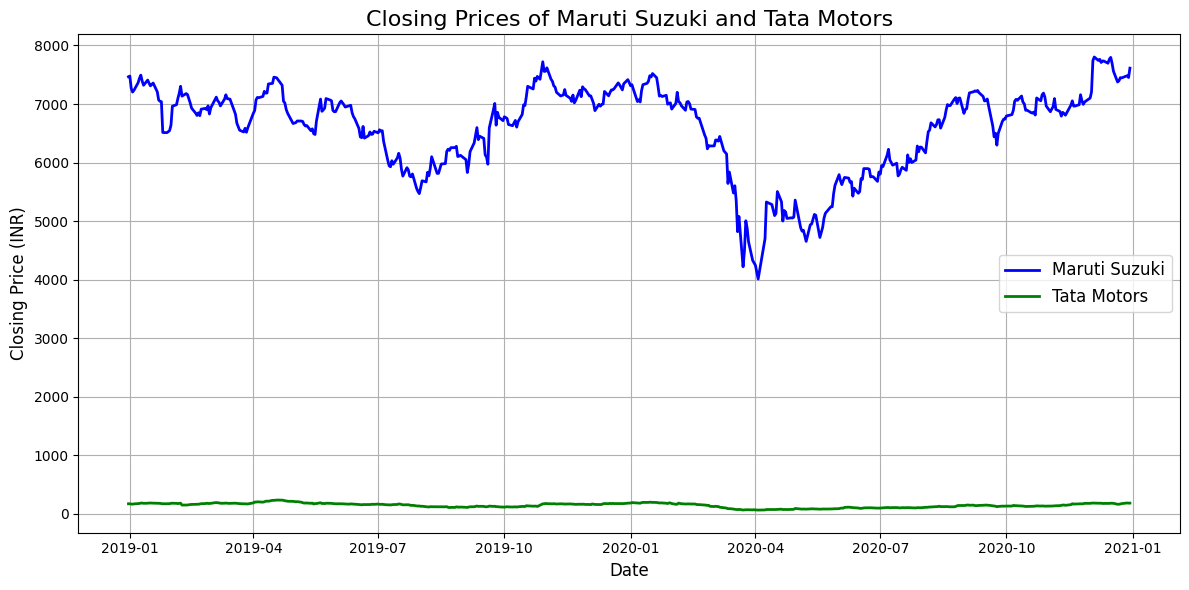

Overall Pearson Correlation: 0.8078


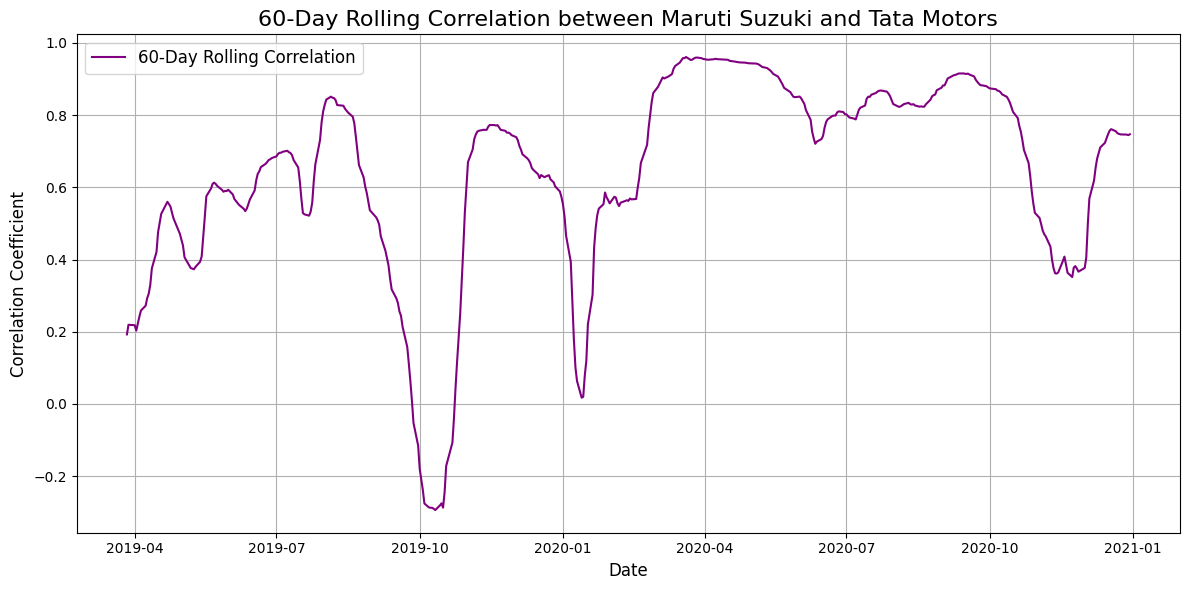

0.807843133498562


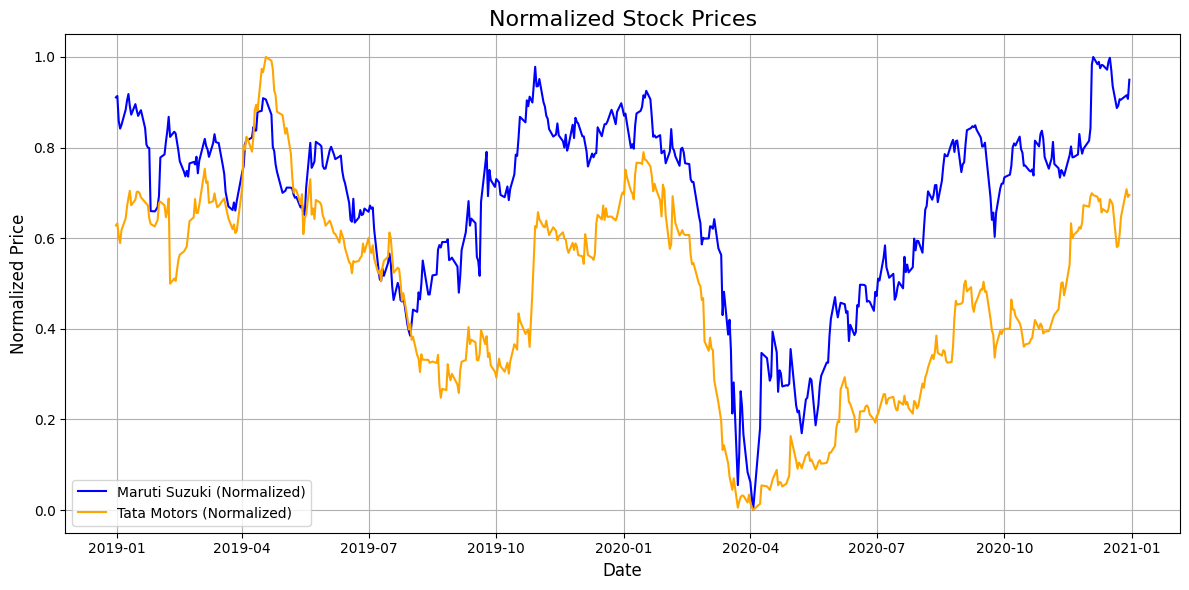

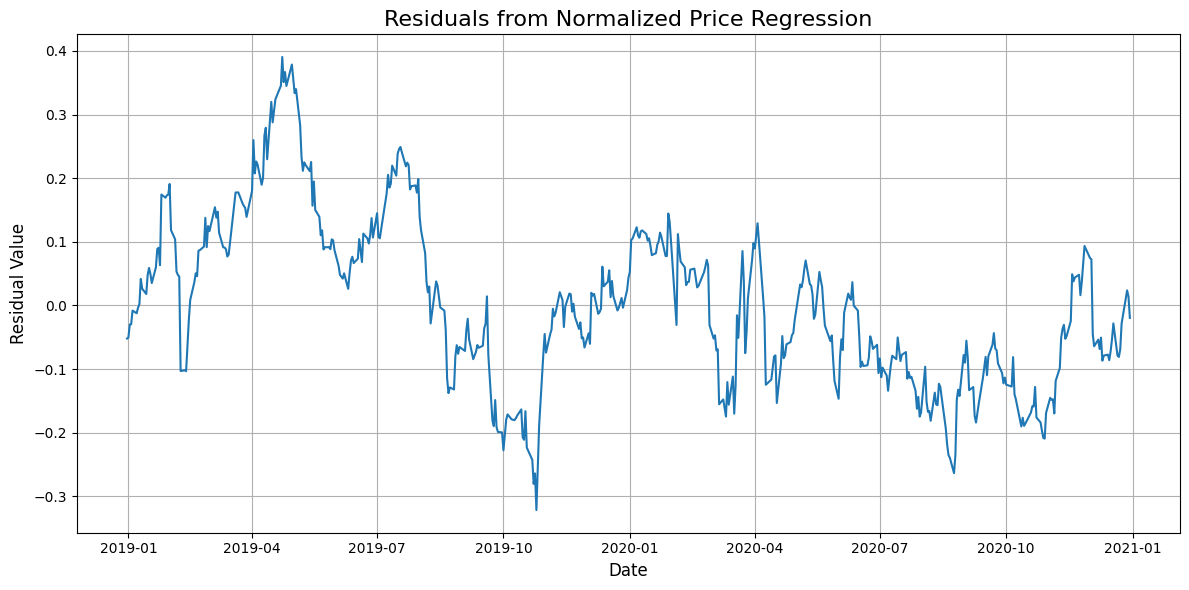


Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.026350260709939
p-value: 0.03250582226533124
Critical Values:
	1%: -3.4436840273842058
	5%: -2.8674204319994674
	10%: -2.5699020441557052

Interpretation:
The residuals are stationary.
Strong evidence of COINTEGRATION.


In [92]:
# Importing the Important libraries that we will use in this Statistical Arbitrage Strategy.
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

# Defining the Stock symbols and timeframe for Maruti Suzuki and Tata Motors
# The reason for choosing these two stocks is they have very low p-value.
# I will explain later why it was important for us to get a low p-value.
symbols = ["MARUTI.NS", "TATAMOTORS.NS"]
start_date = datetime(2018, 12, 31).date()
end_date = datetime(2020,12, 31).date()
# Downloading this data because i am assuming that we will start trading in this stock by 2021.
closing_prices1 = pd.DataFrame() # Creating a pandas dataframe
for symbol in symbols:
    print(f"Downloading data for {symbol}")
    data = yf.download(symbol, start=start_date, end=end_date, interval="1d") # Downloading from yfinance
    closing_prices1[symbol] = data['Close'] # Saving the closing prices in a single dataframe for both of the stocks.

plt.figure(figsize=(12, 6))
plt.plot(closing_prices1.index, closing_prices1["MARUTI.NS"], label="Maruti Suzuki", color="blue", linewidth=2)
plt.plot(closing_prices1.index, closing_prices1["TATAMOTORS.NS"], label="Tata Motors", color="green", linewidth=2)
plt.title("Closing Prices of Maruti Suzuki and Tata Motors", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Closing Price (INR)", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

# Checking the correlation between these two stocks, a correlation of > 0.8 means the stocks are highly correlated that's what we want but that's not the only thing to check
def perform_correlation_analysis(closing_prices):
    # performing the coorelation part.
    overall_correlation = closing_prices["MARUTI.NS"].corr(closing_prices["TATAMOTORS.NS"])
    print(f"Overall Pearson Correlation: {overall_correlation:.4f}")
    # creating the correlation rolling window for 60 days time period and visualizing it.
    rolling_correlation = closing_prices["MARUTI.NS"].rolling(window=60).corr(closing_prices["TATAMOTORS.NS"])
    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, rolling_correlation, label='60-Day Rolling Correlation', color='purple')
    plt.title('60-Day Rolling Correlation between Maruti Suzuki and Tata Motors', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Correlation Coefficient', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return overall_correlation

results = perform_correlation_analysis(closing_prices1)
print(results)
# I have the data of these stocks from 2018 to 2020, we will start our trading from 2021.
# Performing Normalized Cointegration Test, this test is most important, we have to check for the p-value, if it is good then then we can select the stock pair
def normalize_prices(series): # normalizing function for the stock prices.
    return (series - series.min()) / (series.max() - series.min())
# Here we can not say that this strategy has look ahead bias becuase i am running the correlation test on the old data.
def perform_normalized_cointegration_test(closing_prices):
    # normalising both of the stock prices.
    x_normalized = normalize_prices(closing_prices["MARUTI.NS"])
    y_normalized = normalize_prices(closing_prices["TATAMOTORS.NS"])
    # plotting the normalised stock prices on the same chart.
    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, x_normalized, label='Maruti Suzuki (Normalized)', color='blue')
    plt.plot(closing_prices.index, y_normalized, label='Tata Motors (Normalized)', color='orange')
    plt.title('Normalized Stock Prices', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Price', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # applying linear regression(ordinary least squares)
    # We can apply linear regression just to see whether p-value<0.05 or not.
    X = sm.add_constant(x_normalized)
    model = sm.OLS(y_normalized, X).fit()
    residuals = model.resid
    # plotting the residuals after performing linear regression.
    plt.figure(figsize=(12, 6))
    plt.plot(closing_prices.index, residuals)
    plt.title('Residuals from Normalized Price Regression', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Residual Value', fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # now performing the adf test.
    adf_result = adfuller(residuals.dropna())
    print('\nAugmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {adf_result[0]}')
    print(f'p-value: {adf_result[1]}') # this p value is important.
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'\t{key}: {value}')
    print("\nInterpretation:")
    if adf_result[1] <= 0.05:
        print("The residuals are stationary.")
        print("Strong evidence of COINTEGRATION.")
    else:
        print("The residuals are NOT stationary.")
        print("Weak or NO evidence of cointegration.")
    return {'normalized_prices': {'Maruti Suzuki': x_normalized, 'Tata Motors': y_normalized}, 'residuals': residuals}

normalized_cointegration_results = perform_normalized_cointegration_test(closing_prices1)


In [93]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

symbols = ["MARUTI.NS", "TATAMOTORS.NS"]
# Downloading the 4 years of data.
start_date = datetime(2020, 12, 31).date()
end_date = datetime(2024,12, 31).date()

closing_prices = pd.DataFrame() # creating a pandas dataframe
for symbol in symbols:
    print(f"Downloading data for {symbol}")
    data = yf.download(symbol, start=start_date, end=end_date, interval="1d") # Downloading from yfinance
    closing_prices[symbol] = data['Close'] # Saving the closing prices in a single dataframe for both of the stocks.

def generate_trading_signals_rolling(closing_prices, lookback_period=125, z_score_threshold=1.5):
    """
    Generate trading signals using a rolling window approach.

    Parameters:
    -----------
    closing_prices : pandas.DataFrame
        DataFrame containing closing prices for two stocks
    lookback_period : int
        Number of days to use for calculating the regression parameters
    z_score_threshold : float
        Threshold for entering trading positions

    Returns:
    --------
    signals : pandas.DataFrame
        DataFrame containing trading signals and spread information
    """
    # Get stock names
    stock1 = closing_prices.columns[0]
    stock2 = closing_prices.columns[1]

    # Initialize signals DataFrame
    signals = pd.DataFrame(index=closing_prices.index)
    signals['spread'] = np.nan
    signals['spread_z_score'] = np.nan
    signals[f'{stock1}_signal'] = 0
    signals[f'{stock2}_signal'] = 0

    # Normalize prices function
    def normalize_prices(series):
        return (series - series.min()) / (series.max() - series.min())

    # Start from lookback_period
    active_long = False
    active_short = False

    # Process each day after the initial lookback period
    for i in range(lookback_period, len(closing_prices)):
        # Get the historical data up to current day
        # for the 1st time i= lookback_period.
        # this window will be from first day to lookback_period-1 day
        historical_data = closing_prices.iloc[i-lookback_period:i]

        # Normalize prices for the historical window
        x_normalized = normalize_prices(historical_data[stock1])
        y_normalized = normalize_prices(historical_data[stock2])

        # Perform linear regression on historical data
        X = sm.add_constant(x_normalized)
        model = sm.OLS(y_normalized, X).fit()

        # Calculate spread for the current day using the model
        current_x = normalize_prices(closing_prices[stock1].iloc[i-lookback_period:i+1])
        current_y = normalize_prices(closing_prices[stock2].iloc[i-lookback_period:i+1])
        X_current = sm.add_constant(current_x)
        spread = current_y - model.predict(X_current)
        current_spread = spread.iloc[-1]  # Get only the last value

        # Calculate z-score using historical spread
        historical_spread = spread.iloc[:-1]  # Exclude current day
        spread_mean = historical_spread.mean()
        spread_std = historical_spread.std()
        current_z_score = (current_spread - spread_mean) / spread_std

        # Store the spread and z-score
        signals.loc[closing_prices.index[i], 'spread'] = current_spread
        signals.loc[closing_prices.index[i], 'spread_z_score'] = current_z_score

        # Trading logic
        # Long entry condition
        if current_z_score < -z_score_threshold and not active_long and not active_short:
            signals.loc[closing_prices.index[i], f'{stock1}_signal'] = 1  # Long first stock
            signals.loc[closing_prices.index[i], f'{stock2}_signal'] = -1  # Short second stock
            active_long = True

        # Short entry condition
        elif current_z_score > z_score_threshold and not active_long and not active_short:
            signals.loc[closing_prices.index[i], f'{stock1}_signal'] = -1  # Short first stock
            signals.loc[closing_prices.index[i], f'{stock2}_signal'] = 1  # Long second stock
            active_short = True

        # Mean reversion exit condition
        elif abs(current_z_score) < 0.5:
            if active_long:
                # Exit long position with opposite signals
                signals.loc[closing_prices.index[i], f'{stock1}_signal'] = -1  # Close long first stock
                signals.loc[closing_prices.index[i], f'{stock2}_signal'] = 1  # Close short second stock
                active_long = False
            elif active_short:
                # Exit short position with opposite signals
                signals.loc[closing_prices.index[i], f'{stock1}_signal'] = 1  # Close short first stock
                signals.loc[closing_prices.index[i], f'{stock2}_signal'] = -1  # Close long second stock
                active_short = False

    return signals


signals = generate_trading_signals_rolling(closing_prices, lookback_period=125)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

In [94]:
# Value counts for the rows of the column 'TATAMOTORS.NS_signal'
value_counts = signals['TATAMOTORS.NS_signal'].value_counts()

print(value_counts)


TATAMOTORS.NS_signal
 0    955
-1     16
 1     16
Name: count, dtype: int64


In [95]:
signals['MARUTI.NS_signal'].value_counts()

,count
MARUTI.NS_signal,
0,955
1,16
-1,16


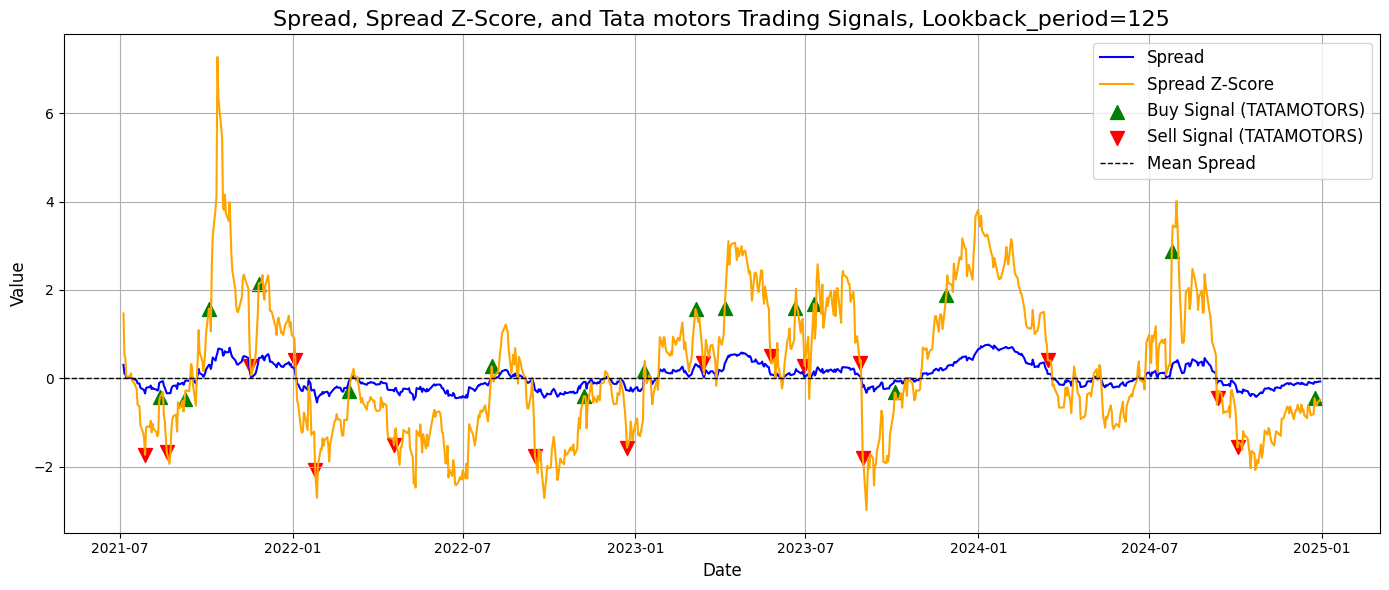

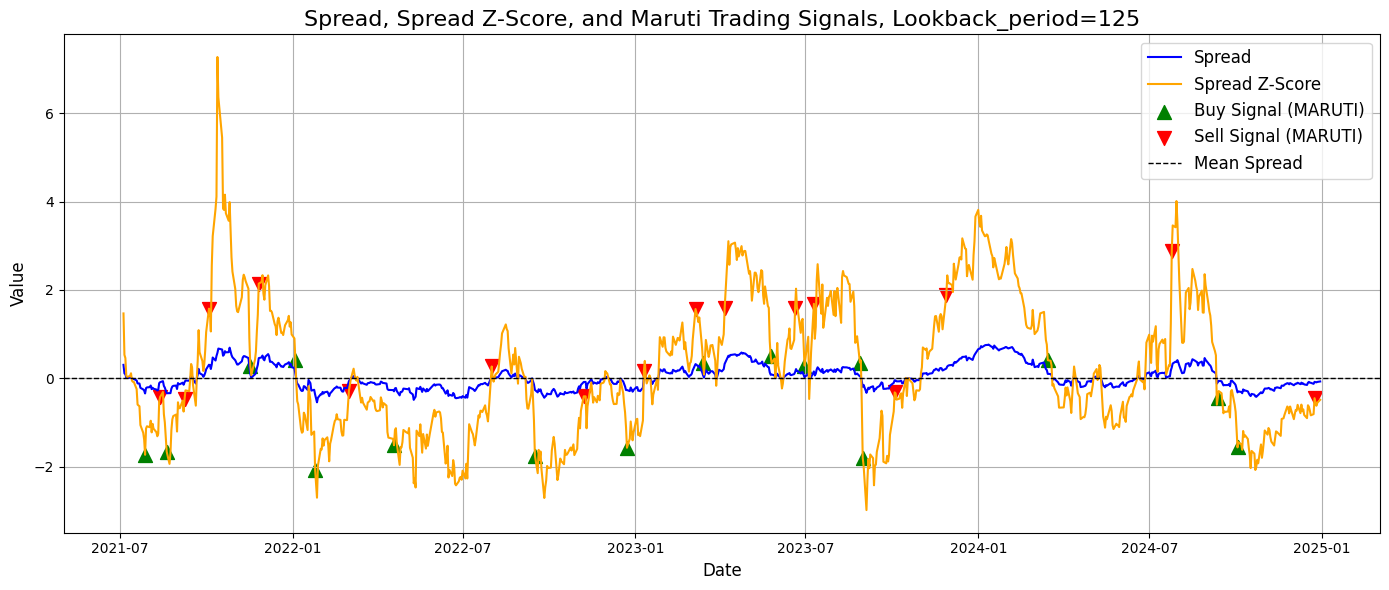

In [96]:
# Plotting the buy-sell singals for tata motors(just for validation purposes)
plt.figure(figsize=(14, 6))

# Plot the spread
plt.plot(signals.index, signals['spread'], label='Spread', color='blue', linewidth=1.5)

# Plot the Z-score of the spread
plt.plot(signals.index, signals['spread_z_score'], label='Spread Z-Score', color='orange', linewidth=1.5)

# Plot the signals as markers
buy_signals = signals[signals["TATAMOTORS.NS_signal"] == 1]
sell_signals = signals[signals["TATAMOTORS.NS_signal"] == -1]

# Plot buy signals
plt.scatter(buy_signals.index, buy_signals['spread_z_score'], color='green', label='Buy Signal (TATAMOTORS)', marker='^', s=100)

# Plot sell signals
plt.scatter(sell_signals.index, sell_signals['spread_z_score'], color='red', label='Sell Signal (TATAMOTORS)', marker='v', s=100)

# Adding chart details
plt.title("Spread, Spread Z-Score, and Tata motors Trading Signals, Lookback_period=125", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Mean Spread')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Plotting the buy-sell singals for maruti suzuki(just for validation puposes)
plt.figure(figsize=(14, 6))

# Plot the spread
plt.plot(signals.index, signals['spread'], label='Spread', color='blue', linewidth=1.5)

# Plot the Z-score of the spread
plt.plot(signals.index, signals['spread_z_score'], label='Spread Z-Score', color='orange', linewidth=1.5)

# Plot the signals as markers
buy_signals = signals[signals["MARUTI.NS_signal"] == 1]
sell_signals = signals[signals["MARUTI.NS_signal"] == -1]

# Plot buy signals
plt.scatter(buy_signals.index, buy_signals['spread_z_score'], color='green', label='Buy Signal (MARUTI)', marker='^', s=100)

# Plot sell signals
plt.scatter(sell_signals.index, sell_signals['spread_z_score'], color='red', label='Sell Signal (MARUTI)', marker='v', s=100)

# Add chart details
plt.title("Spread, Spread Z-Score, and Maruti Trading Signals, Lookback_period=125", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.axhline(0, color='black', linestyle='--', linewidth=1, label='Mean Spread')
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


[*********************100%***********************]  1 of 1 completed


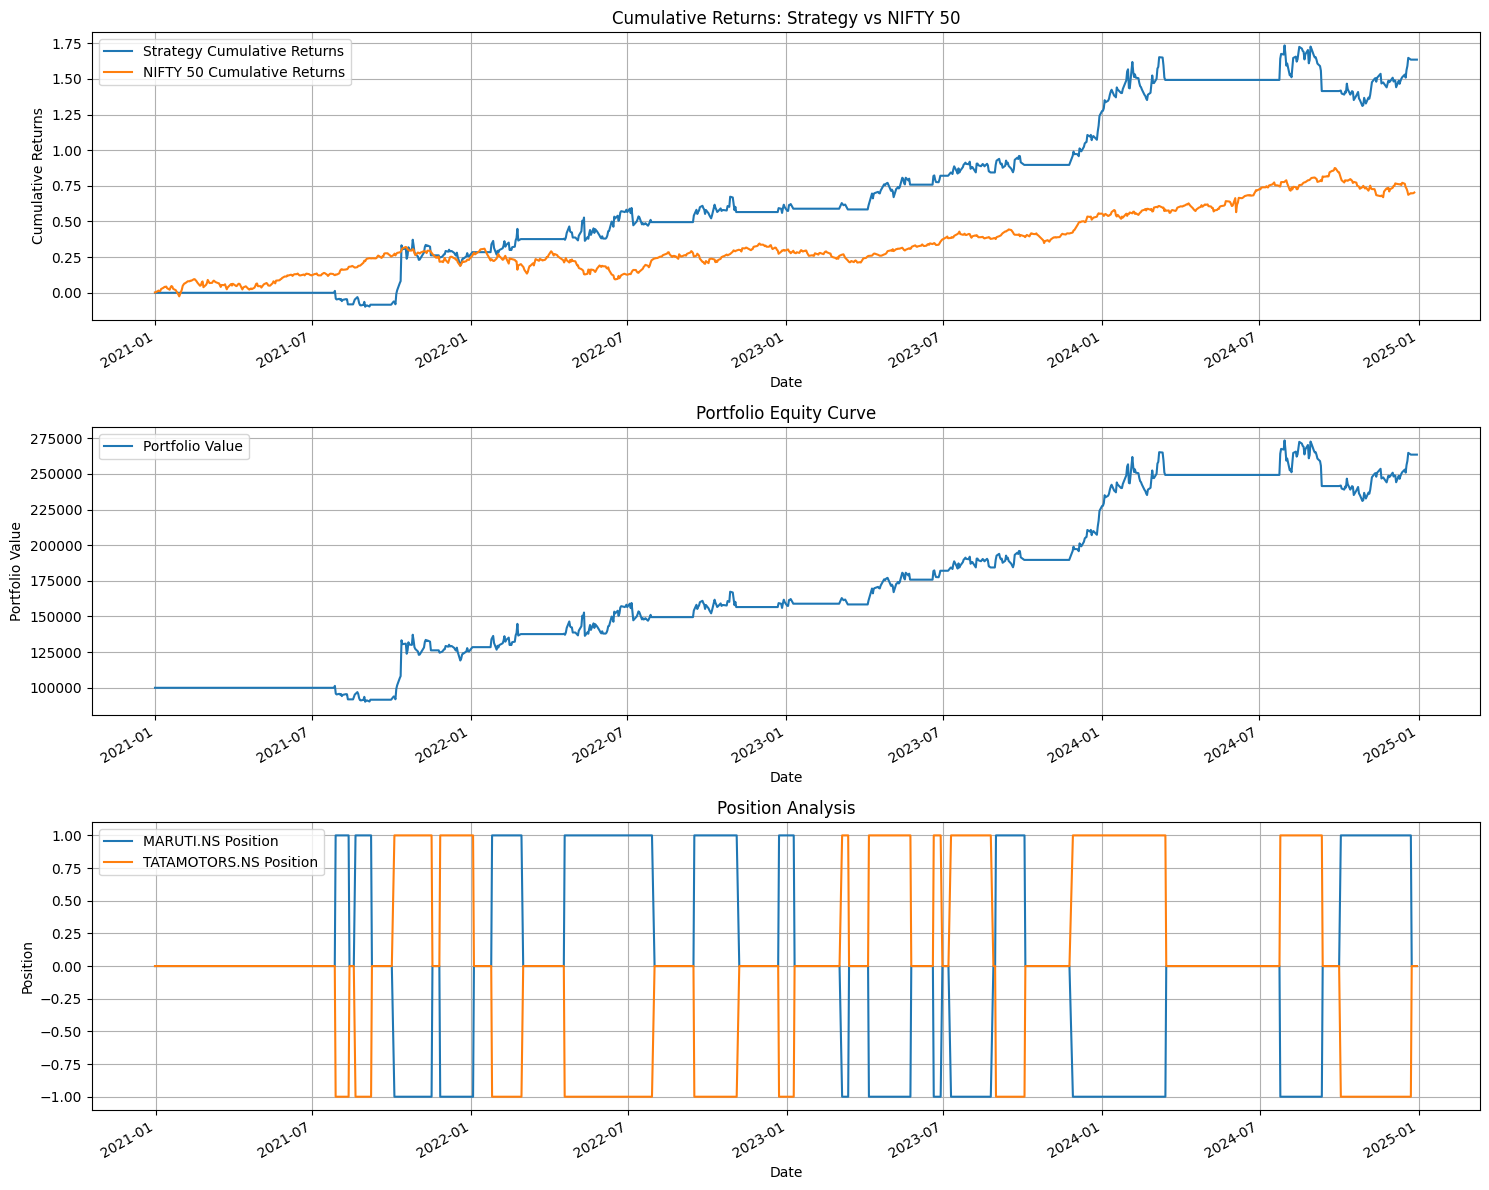

{'Initial Capital': 100000, 'Final Portfolio Value': 263486.035941319, 'Total Return': 1.63486035941319, 'Benchmark Return': 0.703177384134672, 'Sharpe Ratio': 2.0839136264458373, 'Maximum Drawdown': -0.42458276568398956, 'Total Number of Trades': 66}


In [97]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

def backtest_statistical_arbitrage(closing_prices, signals, initial_capital=100000):
    """
    Perform backtesting for a statistical arbitrage strategy with position tracking.

    Parameters:
    -----------
    closing_prices : pandas.DataFrame
        DataFrame with closing prices for both stocks
    signals : pandas.DataFrame
        DataFrame with trading signals for both stocks
    initial_capital : float, optional
        Initial capital for the strategy (default: $100,000)

    Returns:
    --------
    backtest_results : dict
        Dictionary containing various performance metrics and DataFrames
    """
    # Identify stock columns
    stock1 = closing_prices.columns[0]
    stock2 = closing_prices.columns[1]
    signal_col1 = f'{stock1}_signal'
    signal_col2 = f'{stock2}_signal'

    # Create a copy of closing prices and signals
    prices = closing_prices.copy()
    strategy_signals = signals.copy()

    # Calculate daily returns for both stocks
    prices['returns_1'] = prices[stock1].pct_change()
    prices['returns_2'] = prices[stock2].pct_change()

    # Initialize portfolio tracking variables
    portfolio = pd.DataFrame(index=prices.index)
    # Initialize columns with zeros
    portfolio['position_1'] = 0
    portfolio['position_2'] = 0
    capital_per_stock = initial_capital / 2

    # Create position arrays
    position_array1 = np.zeros(len(portfolio))
    position_array2 = np.zeros(len(portfolio))

    # Track positions and calculate position-based returns
    current_position1 = 0
    current_position2 = 0

    # Calculate positions first
    for i in range(1, len(portfolio)):
        # Update positions based on signals
        if strategy_signals[signal_col1].iloc[i] != 0:
            if current_position1 == 0:
                current_position1 = strategy_signals[signal_col1].iloc[i]
            else:
                current_position1 = 0

        if strategy_signals[signal_col2].iloc[i] != 0:
            if current_position2 == 0:
                current_position2 = strategy_signals[signal_col2].iloc[i]
            else:
                current_position2 = 0

        # Store positions in arrays
        position_array1[i] = current_position1
        position_array2[i] = current_position2

    # Assign position arrays to DataFrame in one step
    portfolio.loc[:, 'position_1'] = position_array1
    portfolio.loc[:, 'position_2'] = position_array2

    # Calculate position-weighted returns
    portfolio['stock1_strategy_return'] = portfolio['position_1'] * prices['returns_1']
    portfolio['stock2_strategy_return'] = portfolio['position_2'] * prices['returns_2']
    portfolio['strategy_return'] = portfolio['stock1_strategy_return'] + portfolio['stock2_strategy_return']

    # Calculate equity curve
    portfolio['equity_curve'] = (1 + portfolio['strategy_return']).cumprod() * initial_capital

    # Calculate cumulative strategy returns
    portfolio['cumulative_strategy_return'] = (portfolio['equity_curve'] / initial_capital) - 1

    # Calculate benchmark returns (using NIFTY 50)
    try:
        nifty = yf.download('^NSEI', start=prices.index[0], end=prices.index[-1])['Close']
        nifty_returns = nifty.pct_change()
        portfolio['benchmark_return'] = nifty_returns
        portfolio['cumulative_benchmark_return'] = (1 + nifty_returns).cumprod() - 1
    except:
        print("Warning: Unable to download benchmark data. Proceeding without benchmark comparison.")
        portfolio['benchmark_return'] = 0
        portfolio['cumulative_benchmark_return'] = 0

    # Performance Calculations
    trading_days = len(signals)-125
    sharpe_ratio = portfolio['strategy_return'].mean() / portfolio['strategy_return'].std() * np.sqrt(trading_days)
    max_drawdown = (portfolio['cumulative_strategy_return'] - portfolio['cumulative_strategy_return'].cummax()).min()

    # Plotting
    plt.figure(figsize=(15, 12))

    # Plot 1: Cumulative Returns Comparison
    plt.subplot(3, 1, 1)
    portfolio['cumulative_strategy_return'].plot(label='Strategy Cumulative Returns')
    portfolio['cumulative_benchmark_return'].plot(label='NIFTY 50 Cumulative Returns')
    plt.title('Cumulative Returns: Strategy vs NIFTY 50')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)

    # Plot 2: Equity Curve
    plt.subplot(3, 1, 2)
    portfolio['equity_curve'].plot(label='Portfolio Value')
    plt.title('Portfolio Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)

    # Plot 3: Position Analysis
    plt.subplot(3, 1, 3)
    portfolio['position_1'].plot(label=f'{stock1} Position')
    portfolio['position_2'].plot(label=f'{stock2} Position')
    plt.title('Position Analysis')
    plt.xlabel('Date')
    plt.ylabel('Position')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Calculate additional performance metrics
    total_trades = (portfolio['position_1'].diff() != 0).sum() + (portfolio['position_2'].diff() != 0).sum()

    # Performance Summary
    performance_summary = {
        'Initial Capital': initial_capital,
        'Final Portfolio Value': portfolio['equity_curve'].iloc[-1],
        'Total Return': portfolio['cumulative_strategy_return'].iloc[-1],
        'Benchmark Return': portfolio['cumulative_benchmark_return'].iloc[-2],
        'Sharpe Ratio': sharpe_ratio,
        'Maximum Drawdown': max_drawdown,
        'Total Number of Trades': total_trades,
    }

    return {
        'portfolio': portfolio,
        'performance': performance_summary,
        'signals': strategy_signals
    }


results = backtest_statistical_arbitrage(closing_prices, signals)
print(results['performance'])